In [3]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import scipy
import pickle
import os

from typing import List, Tuple

## Information upfront:
Please note that this work has been tested on our own workflow: https://www.mdpi.com/1424-8220/22/16/5969 and it is possible that it may not work as expected in other environments or with different data. If something is not working or unclear please contact: maximilian.ehrhart@plus.ac.at


In [4]:
from synthesizers.preprocessing.wesad import Subject, WESADDataset

In [4]:
SAMPLING_RATE = 1
DATA_PATH = os.path.realpath("/Users/nils/master/Stress-Detection-From-Wearables/data/WESAD")
SUBJECT_NUMS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

wesad_dataset = WESADDataset(DATA_PATH, SUBJECT_NUMS)

# Get preprocessed data for each subject as a dictionary of dataframes
subject_dataframes = wesad_dataset.get_subject_dataframes(sampling_rate=SAMPLING_RATE)

# Get concatenated preprocessed data for all subjects as a single dataframe
df = wesad_dataset.get_all_data(sampling_rate=SAMPLING_RATE)

In [5]:
df = pd.read_csv('data/wesad_all_1hz.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'data/wesad_all_1hz.csv'

In [9]:
df.to_csv("wesad_all_64hz.csv")

In [7]:
SIGTOI = {"BVP": 0, "EDA": 1, "ACC_x": 2, "ACC_y": 3, "ACC_z": 4, "TEMP": 5}


In [8]:
ITOSIG = {0: 'BVP', 1: 'EDA', 2: 'ACC_x', 3: 'ACC_y', 4: 'ACC_z', 5: 'TEMP'}

In [9]:
df_label = df['label']
df_stress = df[df['label']==1]
df_no_stress = df[df['label']==0]

In [10]:
df_stress

BVP       EDA     ACC_x     ACC_y     ACC_z      TEMP  label
1144   0.468149  0.474020  0.419026  0.058139  0.564404  0.442450    1.0
1145   0.580791  0.465606  0.380185  0.048626  0.545889  0.440526    1.0
1146   0.535289  0.464349  0.386764  0.048625  0.529446  0.442391    1.0
1147   0.529677  0.464895  0.493331  0.080464  0.476120  0.440416    1.0
1148   0.616257  0.456615  0.392069  0.052896  0.535317  0.442802    1.0
...         ...       ...       ...       ...       ...       ...    ...
33147  0.464562  0.093303  0.302460  0.406114  0.638581  0.451159    1.0
33148  0.514509  0.105320  0.639227  0.036187  0.515114  0.427489    1.0
33149  0.401539  0.097959  0.689817  0.018614  0.515933  0.422366    1.0
33150  0.256045  0.058040  0.256639  0.324257  0.517111  0.421627    1.0
33151  0.552329  0.112766  0.229436  0.525320  0.750153  0.424756    1.0

[9966 rows x 7 columns]

<Axes: >

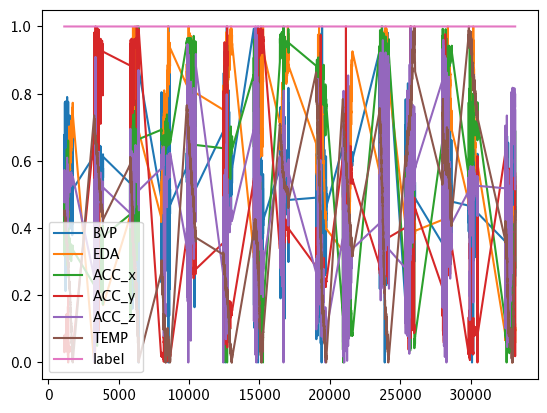

In [11]:
df_stress.plot()

In [12]:
df_no_stress

BVP       EDA     ACC_x     ACC_y     ACC_z      TEMP  label
0      0.346210  1.000000  0.739452  0.461699  0.689519  0.955839    0.0
1      0.594455  0.977662  0.715105  0.325097  0.718060  0.953973    0.0
2      0.495986  0.973092  0.625460  0.361836  0.780076  0.958947    0.0
3      0.526112  0.960576  0.642609  0.329826  0.763401  0.961039    0.0
4      0.575111  0.940889  0.641003  0.352274  0.769356  0.960800    0.0
...         ...       ...       ...       ...       ...       ...    ...
32424  0.435431  0.057751  0.256088  0.854880  0.473135  0.422345    0.0
32425  0.419498  0.056142  0.260715  0.859888  0.473302  0.431595    0.0
32426  0.440691  0.057093  0.256675  0.854527  0.473743  0.431584    0.0
32427  0.422431  0.056556  0.263202  0.859724  0.475137  0.440157    0.0
32428  0.438818  0.054521  0.266577  0.859931  0.468691  0.429067    0.0

[23186 rows x 7 columns]

<AxesSubplot: >

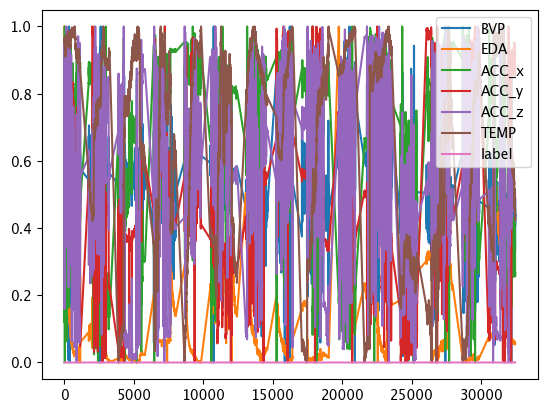

In [18]:
df_no_stress.plot()

In [13]:

def create_windows_new(df: pd.DataFrame, fs: int) -> Tuple[np.ndarray,list]:
    """Creates windows from the dataframe and returns the windows and the labels.
    If the window is assigned to multiple labels, the most common label is chosen for that period.

    Args:
        df (pd.DataFrame): Subject DataFrame
        fs (int): Samples per second

    Returns:
        tuple[np.ndarray,list]: Windows representing the activity of the subject in one minute and the corresponding labels.
    """
    # Create an empty list for the windows and labels
    windows = []
    labels = []

    # Calculate the window length in samples
    window_len = fs * 60

    # Loop over the rows in the DataFrame to create the windows
    for i in range(0, df.shape[0]-window_len, window_len):
        # Get the window data and label
        window = df[i:i+window_len]
        label = int(check_for_stress(df['label'][i:i+window_len].to_list()))

        # Convert the window data to a numpy array
        window = window.to_numpy()

        # Add the window and label to the list
        windows.append(window)
        labels.append(label)

    # Convert the windows and labels to numpy arrays
    windows = np.array(windows)
    labels = np.array(labels)

    # Return the windows and labels as a tuple
    return windows, labels


In [14]:
seq_length = 60
fs = 1
trainX, label_trainX = create_windows_new(df, fs)
mos, _ = create_windows_new(df_stress, fs)#[:512]
non_mos, _ = create_windows_new(df_no_stress, fs)#[:1280]

NameError: name 'check_for_stress' is not defined

In [25]:
trainX = np.delete(trainX, 6, axis=2)
mos = np.delete(mos, 6, axis=2)
non_mos = np.delete(non_mos, 6, axis=2)

In [26]:
trainX.shape

(552, 60, 6)

In [27]:
label_trainX.shape

(552,)

In [28]:
def data_split(data, n_split):
    n = int(n_split * len(data))a
    train_data = data[:n]
    val_data = data[n:]
    return train_data, val_data

In [29]:
num_split = 0.8
trainmos, testmos = data_split(mos, num_split)
trainnomos, testnomos = data_split(non_mos, num_split)

In [30]:
print(trainmos.shape)
print(testmos.shape)
print(trainnomos.shape)
print(testnomos.shape)

(132, 60, 6)
(34, 60, 6)
(308, 60, 6)
(78, 60, 6)


In [31]:
## Define Hyperparameters here
## Maybe you have to check if it is working to change number of features, because we used two in our paper
num_features = trainX.shape[2]

# I used the same shape for latent_dim as for seq_length
# Maybe you have to change something in the code if you want to change that behavior
seq_length = 60
latent_dim = seq_length

batch_size = 32
# LSTM hidden units
hidden_units = 16

# fill in your data here
#trainX = 0
#label_trainX = 0

# Mos are the positive samples and nonMos are the negative samples
# If you want to use the GANmonitor you have to stick with this naming
# Else you have to change them in the code
# trainmos = 0
# trainnomos = 0
# testmos = 0
# testnomos = 0

# Dataset to for the GAN
dataset = tf.data.Dataset.from_tensor_slices((trainX, label_trainX))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 60, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Define Conditional GAN with Keras Tensorflow

## Custom Callback to Evaluate GAN Training

In [32]:
# Helper functions for evaluation of the GAN training
# Generate Synthetic Data
def synthetic_dataset(stressdata, nostressdata):
        
        labels = np.ones((stressdata.shape[0], 1))
        
        labels_nomos = np.zeros((nostressdata.shape[0], 1))
        

        trainX_classifier_synthetic = np.concatenate([stressdata, nostressdata], axis = 0)
        trainy_classifier_synthetic = np.concatenate([labels, labels_nomos], axis = 0)
        return trainX_classifier_synthetic, trainy_classifier_synthetic

# Plot the generated data in a 2x2 grid subplot
def generate_and_plot_data(predictions, predictions2, samples, seq_length):
    
    fig = make_subplots(rows=3, cols=2, subplot_titles=("BVP_MOS", "BVP_NoMOS", "EDA_MOS", "EDA_NoMOS", "TEMP_MOS", "TEMP_noMOS") )


    for i in range(samples):
        fig.add_trace(
            go.Scatter(y=predictions[i,:,0], mode = "lines"),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(y=predictions2[i,:,0], mode = "lines"),
            row=1, col=2
        )

        fig.add_trace(
            go.Scatter(y=predictions[i,:,1], mode = "lines"),
            row=2, col=1
        )

        fig.add_trace(
            go.Scatter(y=predictions2[i,:,1], mode = "lines"),
            row=2, col=2
        )

        fig.add_trace(
            go.Scatter(y=predictions[i,:,5], mode = "lines"),
            row=3, col=1
        )

        fig.add_trace(
            go.Scatter(y=predictions2[i,:,5], mode = "lines"),
            row=3, col=2
        )
    
    return fig.show()

# Build a Data set for Classifier Two sample Test
def buildDataCTST(synthMos, synthNoMos, realMos, realNoMos, synthTestMos, synthTestNoMos, realTestMos, realTestNoMos, seq_length):

    nn_train_mos = np.concatenate([np.reshape(realMos, (realMos.shape[0], seq_length*num_features), order="F"), np.reshape(synthMos, (synthMos.shape[0], seq_length*num_features), order="F")])
    nn_label_mos = np.concatenate([np.zeros((realMos.shape[0])), np.ones((synthMos.shape[0]))])

    nn_train_nomos = np.concatenate([np.reshape(realNoMos, (realNoMos.shape[0], seq_length*num_features), order="F"), np.reshape(synthNoMos, (synthNoMos.shape[0], seq_length*num_features), order="F")])
    nn_label_nomos = np.concatenate([np.zeros((realNoMos.shape[0])), np.ones((synthNoMos.shape[0]))])

    nn_test_mos = np.concatenate([np.reshape(realTestMos, (realTestMos.shape[0], seq_length*num_features), order="F"), np.reshape(synthTestMos, (synthTestMos.shape[0], seq_length*num_features), order="F")])
    nn_label_test_mos = np.concatenate([np.zeros((realTestMos.shape[0])), np.ones((synthTestMos.shape[0]))])

    nn_test_nomos = np.concatenate([np.reshape(realTestNoMos, (realTestNoMos.shape[0], seq_length*num_features), order="F"), np.reshape(synthTestNoMos, (synthTestNoMos.shape[0], seq_length*num_features), order="F")])
    nn_label_test_nomos = np.concatenate([np.zeros((realTestNoMos.shape[0])), np.ones((synthTestNoMos.shape[0]))])
    
    nn_train = np.concatenate([nn_train_mos, nn_train_nomos])
    nn_label = np.concatenate([nn_label_mos, nn_label_nomos])

    nn_test = np.concatenate([nn_test_mos, nn_test_nomos])
    nn_label_test = np.concatenate([nn_label_test_mos, nn_label_test_nomos])
    
    
    return nn_train, nn_label, nn_test, nn_label_test 

# Custom GAN Monitor
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, randomTrainMos, randomTrainNoMos, randomTestMos, randomTestNoMos, num_seq=1, seq_length=18):
        self.randomTrainMos = randomTrainMos
        self.randomTrainNoMos = randomTrainNoMos
        self.randomTestMos = randomTestMos
        self.randomTestNoMos = randomTestNoMos
        self.seq_length = seq_length
        self.scorelist = []
        # how many sequences you want to plot in the grid
        self.num_seq = num_seq

    def on_epoch_end(self, epoch, logs=None):
        
        label_mos = tf.ones((self.randomTrainNoMos.shape[0], 1))
        label_nomos = tf.zeros((self.randomTrainNoMos.shape[0], 1))
        
        synthTrainMos = self.model.generator([self.randomTrainMos, label_mos[:self.randomTrainMos.shape[0]]])
        synthTrainNoMos = self.model.generator([self.randomTrainNoMos, label_nomos])
        synthTestMos = self.model.generator([self.randomTestMos, label_mos[:self.randomTestMos.shape[0]]])
        synthTestNoMos = self.model.generator([self.randomTestNoMos, label_nomos[:self.randomTestNoMos.shape[0]]])
        
        
        label_mos = tf.ones((self.randomTrainMos.shape[0], 1))
        label_nomos = tf.zeros((self.randomTrainMos.shape[0],1))
        stressData = self.model.generator([self.randomTrainMos, label_mos])
        nostressData = self.model.generator([self.randomTrainMos, label_nomos])
        
        # if you want to perform classifier two sample test as well 
        nn_train, nn_label, nn_test, nn_label_test = buildDataCTST(synthTrainMos, synthTrainNoMos, trainmos, trainnomos, synthTestMos, synthTestNoMos, testmos, testnomos, seq_length= self.seq_length)
        
        # Perform Classifier two sample test
        neigh = KNeighborsClassifier(2)
        neigh.fit(nn_train, nn_label)
        c2stScore = neigh.score(nn_test, nn_label_test)
        self.scorelist.append(c2stScore)
        
        if c2stScore <= min(self.scorelist):
             self.model.generator.save(f"models/sixty_seconds/cond_generator_{epoch}_{c2stScore}")
        

        if (epoch) % 250 == 0:
            plt.plot(self.scorelist)
            plt.show()
            generate_and_plot_data(stressData, nostressData, self.num_seq, self.seq_length)
            self.model.generator.save(f"models/sixty_seconds/cond_generator_{epoch}")


In [33]:
#tf.random.set_seed(42)
randomTrainMos = tf.random.normal(shape=(trainmos.shape[0], latent_dim))

#tf.random.set_seed(42)
randomTrainNoMos = tf.random.normal(shape=(trainnomos.shape[0], latent_dim))


#tf.random.set_seed(11)
randomTestMos = tf.random.normal(shape=(testmos.shape[0], latent_dim))

#tf.random.set_seed(11)
randomTestNoMos = tf.random.normal(shape=(testnomos.shape[0], latent_dim))

## conditional GAN training

In [34]:
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from synthesizers.cgan.model import ConditionalGAN
# from synthesizers.cgan.model import conditional_discriminator, conditional_generator

In [4]:
## Define Hyperparameters here
## Maybe you have to check if it is working to change number of features, because we used two in our paper
# num_features = trainX.shape[2]
num_features = 6 #trainX.shape[2]

# I used the same shape for latent_dim as for seq_length
# Maybe you have to change something in the code if you want to change that behavior
seq_length = 60
latent_dim = seq_length

batch_size = 32
# LSTM hidden units
hidden_units = 16


In [13]:
epochs = 1000
tf.random.set_seed(11)

generator = Generator(hidden_units=hidden_units, seq_length=seq_length, latent_dim=latent_dim, num_features=num_features)
discriminator = Discriminator(seq_length=seq_length, num_features=num_features)
cond_gan = ConditionalGAN(
    seq_length=seq_length,
    latent_dim = latent_dim,
    discriminator=discriminator,
    generator=generator
)

cond_gan.compile(
    d_optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=Adam(learning_rate= 0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

history = cond_gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(randomTrainMos, randomTrainNoMos, randomTestMos, randomTestNoMos, num_seq=50, seq_length=seq_length)])

cond_gan.generator.save(f"models/cond_generator_{epochs}")
cond_gan.discriminator.save(f"models/cond_discriminator_{epochs}")


AttributeError: 'Discriminator' object has no attribute '_trainable'

Epoch 1/1000


2023-04-16 16:18:56.138293: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/18 [=========================>....] - ETA: 0s - g_loss: 0.4562 - d_loss: 0.6603 - div_term: 0.2413WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: models/sixty_seconds/cond_generator_0_1.0/assets


INFO:tensorflow:Assets written to: models/sixty_seconds/cond_generator_0_1.0/assets


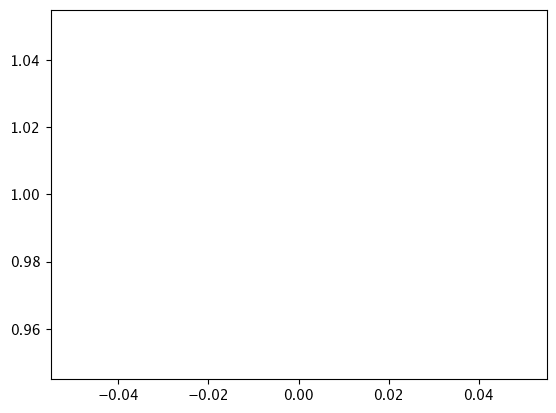

INFO:tensorflow:Assets written to: models/sixty_seconds/cond_generator_0/assets


INFO:tensorflow:Assets written to: models/sixty_seconds/cond_generator_0/assets


18/18 [==============================] - 20s 894ms/step - g_loss: 0.4553 - d_loss: 0.6549 - div_term: 0.2468
Epoch 2/1000
16/18 [=========================>....] - ETA: 0s - g_loss: 0.4348 - d_loss: 0.5289 - div_term: 0.2841WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: models/sixty_seconds/cond_generator_1_1.0/assets


INFO:tensorflow:Assets written to: models/sixty_seconds/cond_generator_1_1.0/assets


18/18 [==============================] - 8s 456ms/step - g_loss: 0.4330 - d_loss: 0.5249 - div_term: 0.2911
Epoch 3/1000
16/18 [=========================>....] - ETA: 0s - g_loss: 0.3918 - d_loss: 0.4729 - div_term: 0.3236WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: models/sixty_seconds/cond_generator_2_0.9955357142857143/assets


INFO:tensorflow:Assets written to: models/sixty_seconds/cond_generator_2_0.9955357142857143/assets


18/18 [==============================] - 8s 463ms/step - g_loss: 0.3907 - d_loss: 0.4743 - div_term: 0.3261
Epoch 4/1000
18/18 [==============================] - 1s 34ms/step - g_loss: 0.3715 - d_loss: 0.5038 - div_term: 0.3969
Epoch 5/1000
18/18 [==============================] - 1s 33ms/step - g_loss: 0.4567 - d_loss: 0.4950 - div_term: 0.5121
Epoch 6/1000
18/18 [==============================] - 1s 34ms/step - g_loss: 0.6421 - d_loss: 0.4211 - div_term: 0.5902
Epoch 7/1000
18/18 [==============================] - 1s 34ms/step - g_loss: 0.7084 - d_loss: 0.4314 - div_term: 0.7253
Epoch 8/1000
18/18 [==============================] - 1s 35ms/step - g_loss: 0.9224 - d_loss: 0.3131 - div_term: 0.8023
Epoch 9/1000
18/18 [==============================] - 1s 34ms/step - g_loss: 0.6279 - d_loss: 0.3540 - div_term: 0.9716
Epoch 10/1000
18/18 [==============================] - 1s 34ms/step - g_loss: 0.2182 - d_loss: 0.3399 - div_term: 1.3354
Epoch 11/1000
18/18 [==============================

INFO:tensorflow:Assets written to: models/sixty_seconds/cond_generator_36_0.9955357142857143/assets


INFO:tensorflow:Assets written to: models/sixty_seconds/cond_generator_36_0.9955357142857143/assets


18/18 [==============================] - 8s 441ms/step - g_loss: -0.4831 - d_loss: 0.4997 - div_term: 1.5184
Epoch 38/1000
18/18 [==============================] - 1s 34ms/step - g_loss: -0.5028 - d_loss: 0.5770 - div_term: 1.3539
Epoch 39/1000
16/18 [=========================>....] - ETA: 0s - g_loss: -0.2538 - d_loss: 0.4724 - div_term: 1.2998WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


KeyboardInterrupt: 

In [35]:
from tensorflow.keras.optimizers.legacy import Adam

epochs = 1000
tf.random.set_seed(11)

cond_gan = ConditionalGAN(
    num_features=num_features,
    seq_length=seq_length,
    latent_dim = latent_dim,
    discriminator=ConditionalGAN.conditional_discriminator(
        seq_length=seq_length, 
        num_features=num_features), 
    generator=ConditionalGAN.conditional_generator(
        hidden_units=hidden_units, 
        seq_length=seq_length, 
        latent_dim=latent_dim,
        num_features=num_features
    )
)

cond_gan.compile(
    d_optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=Adam(learning_rate= 0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

history = cond_gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(randomTrainMos, randomTrainNoMos, randomTestMos, randomTestNoMos, num_seq=50, seq_length=seq_length)])

cond_gan.generator.save(f"models/cond_generator_{epochs}")
cond_gan.discriminator.save(f"models/cond_discriminator_{epochs}")

## Generate Data 

In [61]:
from tensorflow import keras
save_epochs = 2806
generator = keras.models.load_model(f"./models/sixty_seconds/cond_generator_2806_0.65625")
# discriminator = keras.models.load_model("./models/cond_discriminator")

In [62]:
tf.random.set_seed(11)

num_syn_samples = 250
latent_dim = 60

label_no_stress = tf.zeros([num_syn_samples,1])
label_stress = tf.ones([num_syn_samples,1])

random_vector = tf.random.normal(shape=(num_syn_samples,latent_dim))
syn_no_stress = generator([random_vector, label_no_stress])
syn_stress = generator([random_vector, label_stress])

In [63]:
zero = np.zeros([num_syn_samples, 60, 1])
ones = np.ones([num_syn_samples, 60, 1])

In [64]:
no_stress = np.append(np.array(syn_no_stress), zero, axis=2)
stress = np.append(np.array(syn_stress), ones, axis=2)

In [65]:
gen_data = np.concatenate((no_stress, stress))

In [61]:
with open (f"syn_gen_data_{save_epochs}.npy", "wb") as f:
    np.save(f, gen_data)

## Plot data

In [66]:
signal_index = SIGTOI['EDA']

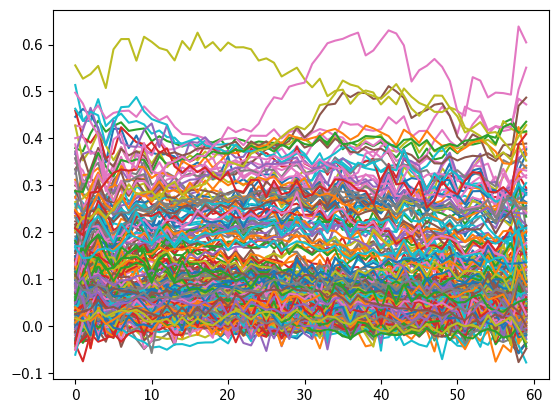

In [67]:
for i in range(syn_no_stress.shape[0]):
    plt.plot(syn_no_stress[i,:,signal_index])

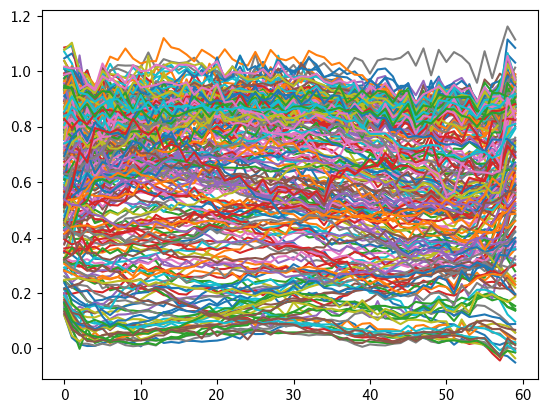

In [68]:
for i in range(syn_stress.shape[0]):
    plt.plot(syn_stress[i,:,signal_index])

In [69]:
trainmos.shape

(7924, 60, 7)

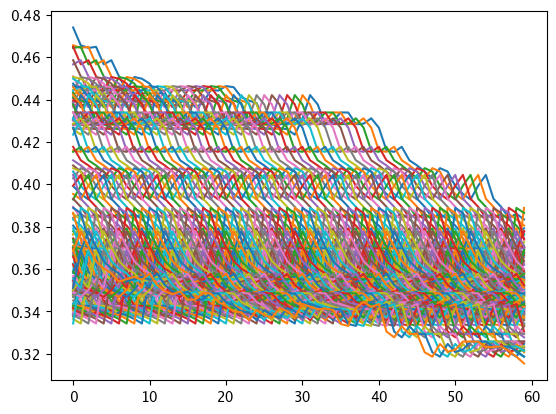

In [70]:
for i in range(132):
    plt.plot(trainmos[i,:,signal_index])

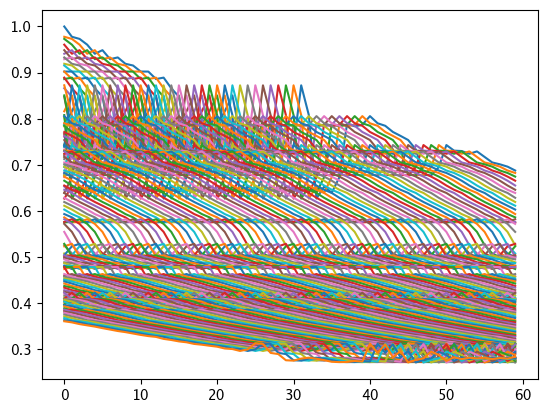

In [71]:
for i in range(132):
    plt.plot(trainnomos[i,:,signal_index])

In [72]:
# Plot the generated data in a 2x2 grid subplot
def plot_synthetic_data(sig_index: int, num_samples: int):
    
    fig = make_subplots(rows=2, cols=2, subplot_titles=("Real Stress", "Synthetic Stress", "Real No Stress", "Synthetic No Stress"))
    fig
    for i in range(num_samples):
        fig.add_trace(
            go.Scatter(y=trainmos[i,:,sig_index], mode = "lines"),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(y=syn_stress[i,:,sig_index], mode = "lines"),
            row=1, col=2
        )

        fig.add_trace(
            go.Scatter(y=trainnomos[i,:,sig_index], mode = "lines"),
            row=2, col=1
        )

        fig.add_trace(
            go.Scatter(y=syn_no_stress[i,:,sig_index], mode = "lines"),
            row=2, col=2
        )
    fig.update_layout(
    title={
        'text': ITOSIG[sig_index],
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    return fig.show()

"Acute stress triggers peripheral vasoconstriction, causing a rapid, short-term drop in skin temperature in homeotherms." - https://bio-medical.com/resources/skin-temperature-reveals-the-intensity-of-acute-stress/

In [73]:
for i in range(len(SIGTOI)):
    plot_synthetic_data(i, 10)

In [74]:
def plot_signal(data, classname):
    fig, axs = plt.subplots(2, 5, figsize=(20,5))
    fig.suptitle(f'{classname}', fontsize=15)
    for i in range(2):
        for j in range(5):
            axs[i, j].plot(data[i*5+j, :, SIGTOI[classname]])

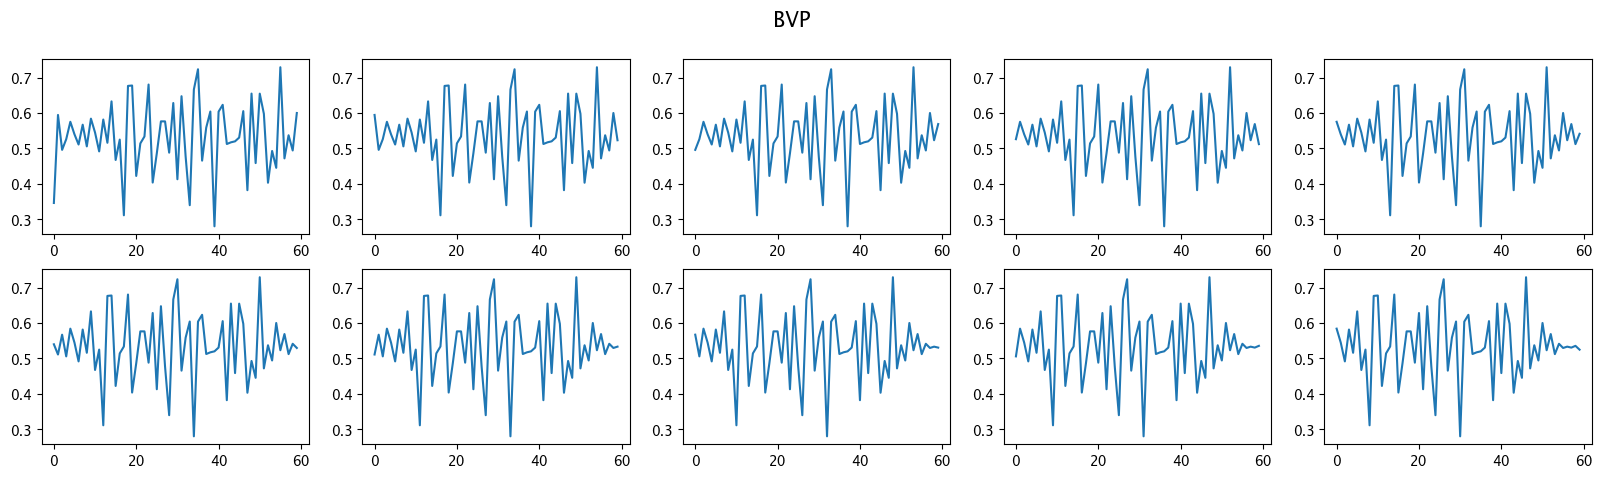

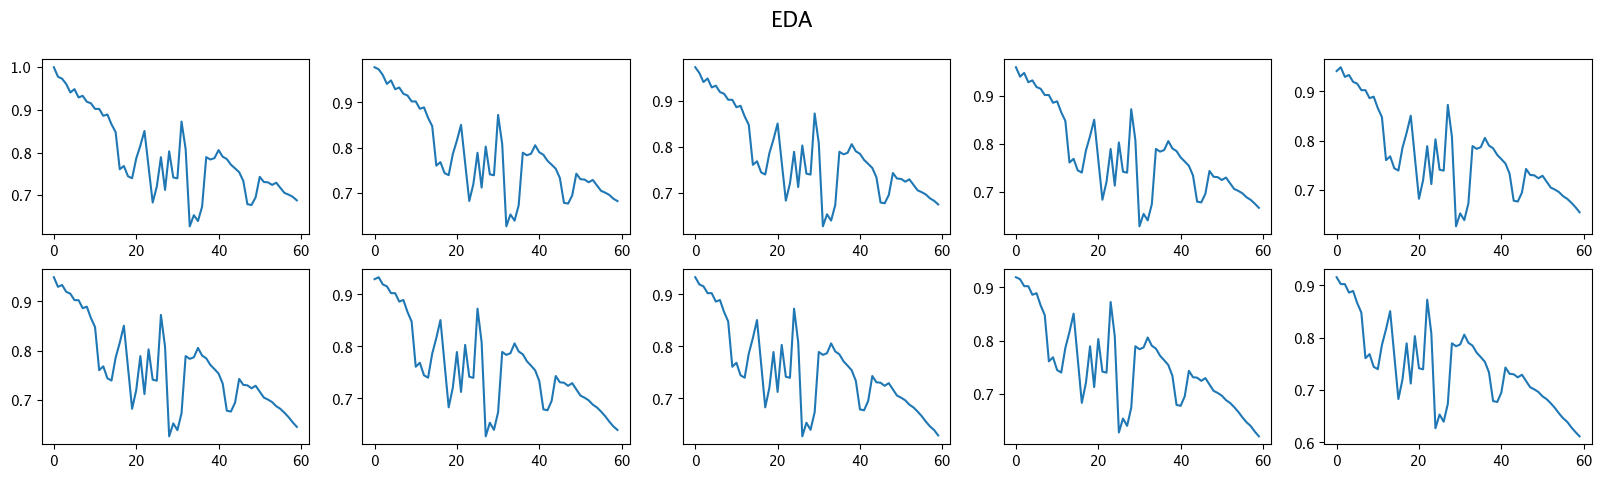

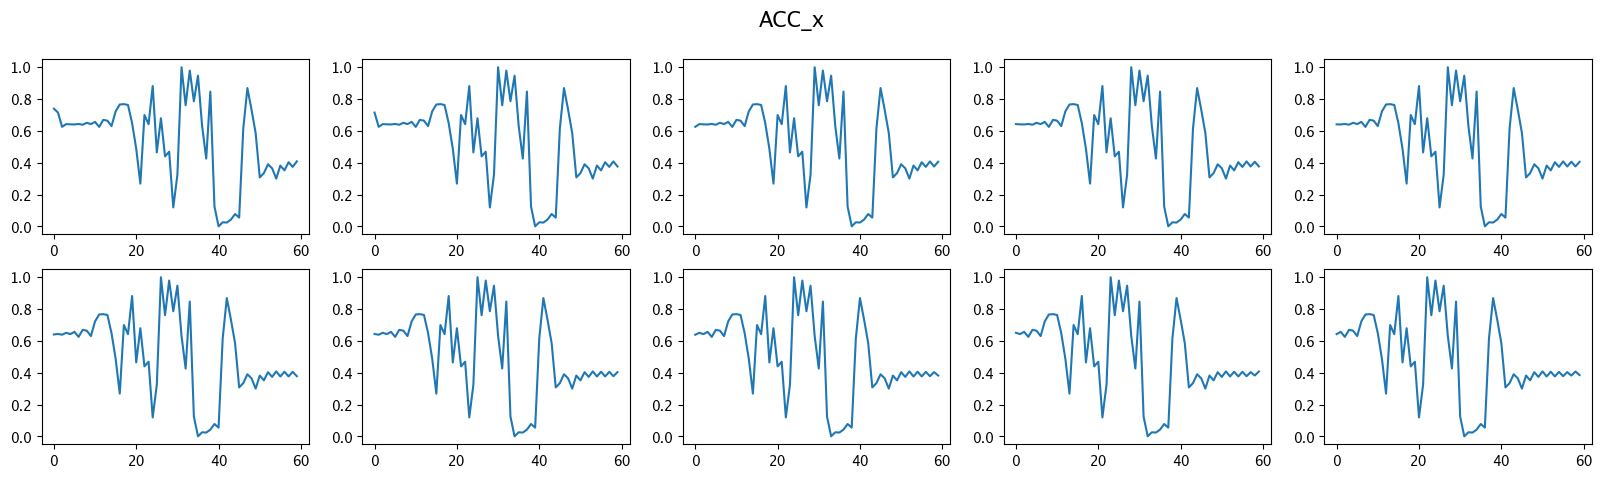

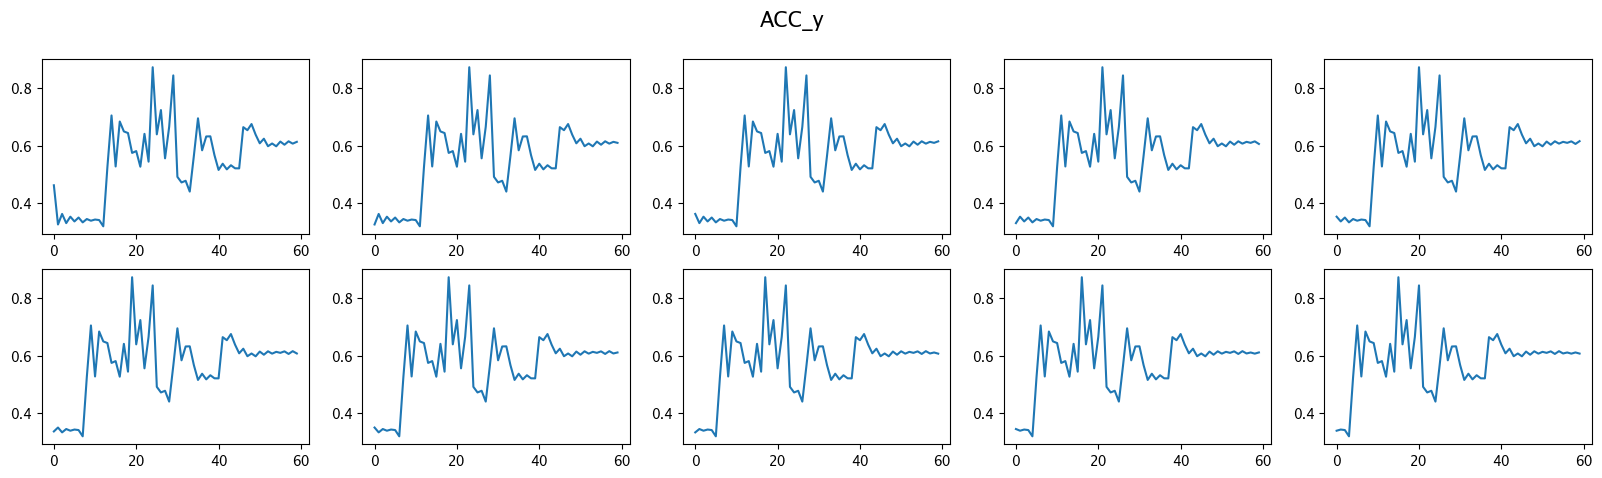

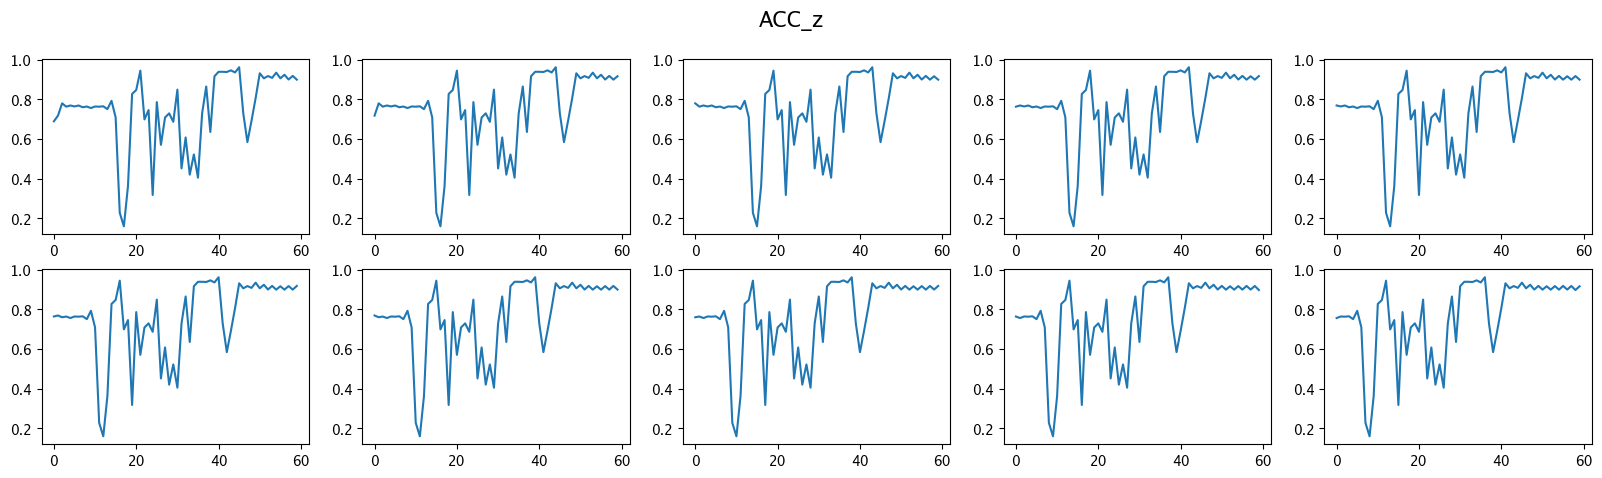

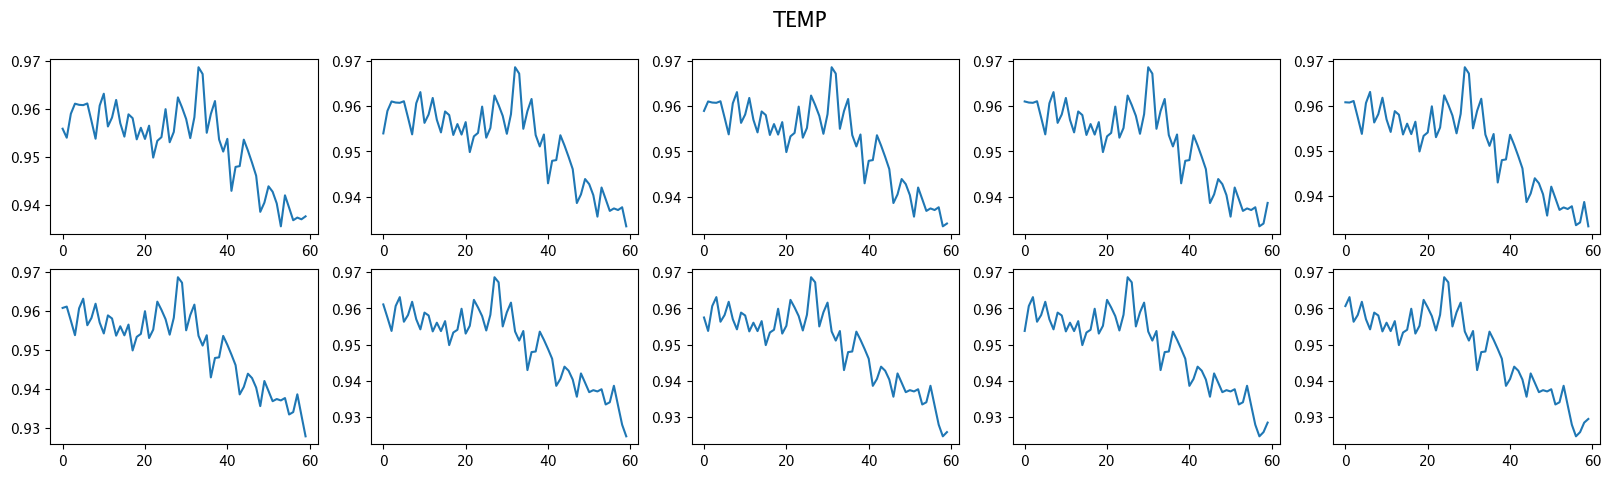

In [75]:
for key in SIGTOI.keys():
    plot_signal(trainnomos, key)

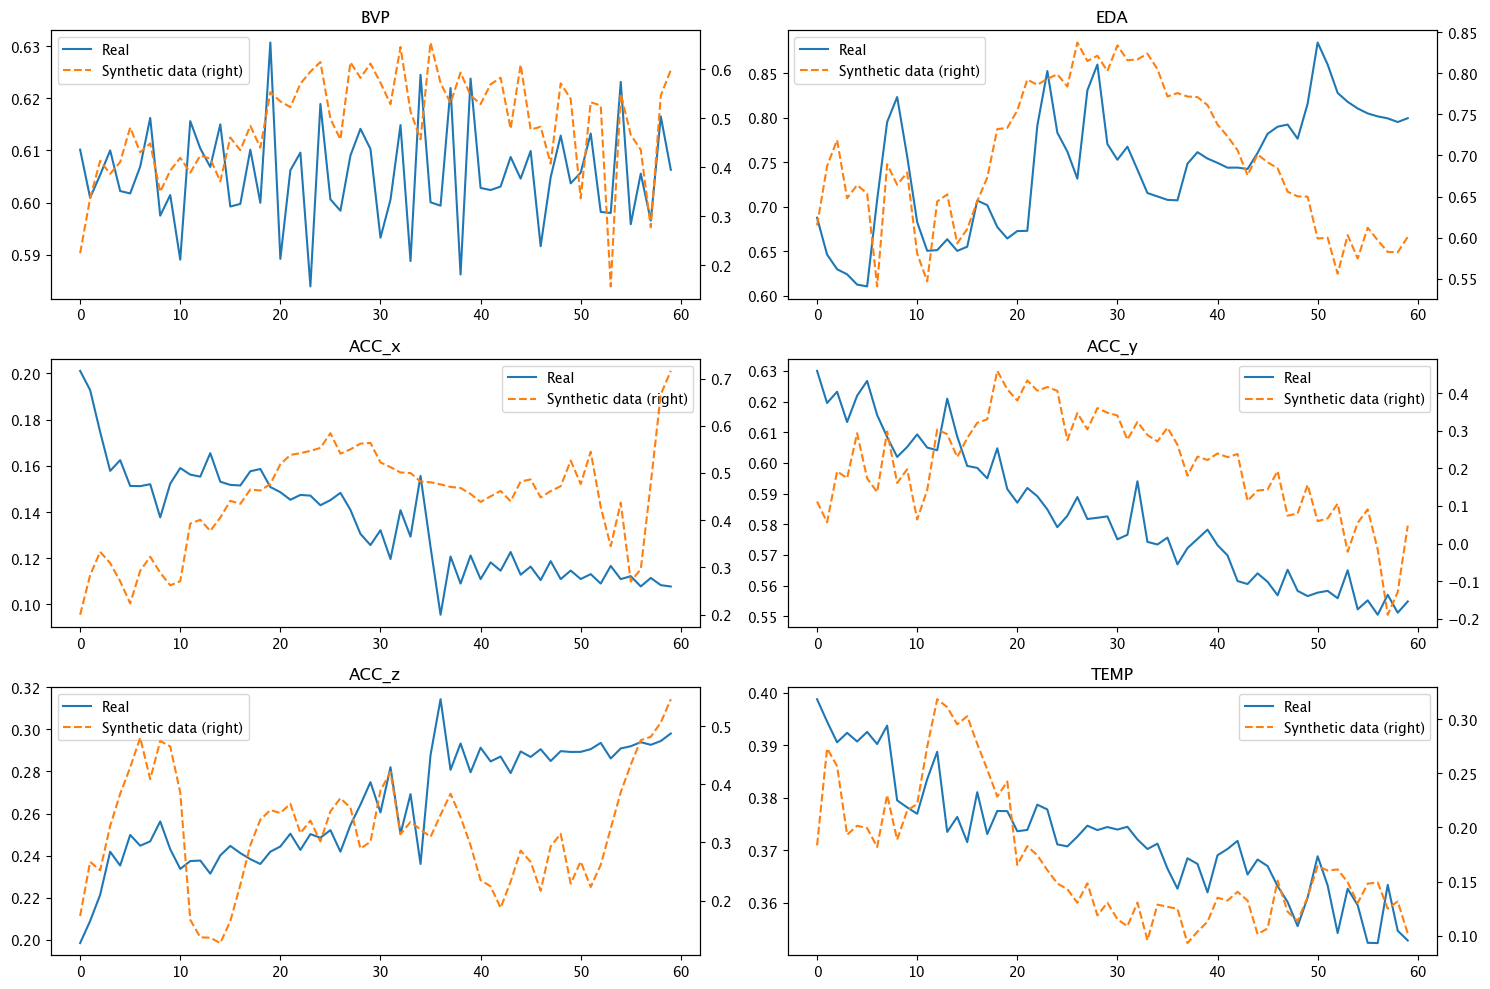

In [217]:
import matplotlib.pyplot as plt

#Reshaping the data
cols = ['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes=axes.flatten()

obs = np.random.randint(len(trainmos))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': trainmos[obs][:, j], 'Synthetic data': syn_stress[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

## Evaluation

EVALUATION: QUALITY ASSESSMENT OPTIONS

1. Diversity—samples should be as distributed as the real data points
Visualization by t-SNE und PCA
2. Fidelity—samples should be indistinguishable from real points
Quantitative measure of equality
Train a binary classifier that distinguishes real data points from generated data points. Original sequence is labeled as real; any generated sequence is labeled as not real.
3. Usefulness—evaluate how well the generated data preserves the predictive characteristics of the original
Train on synthetic, test on real (TSTR) framework

### 1. Diversity

In [76]:
from metric.visualization import visualization

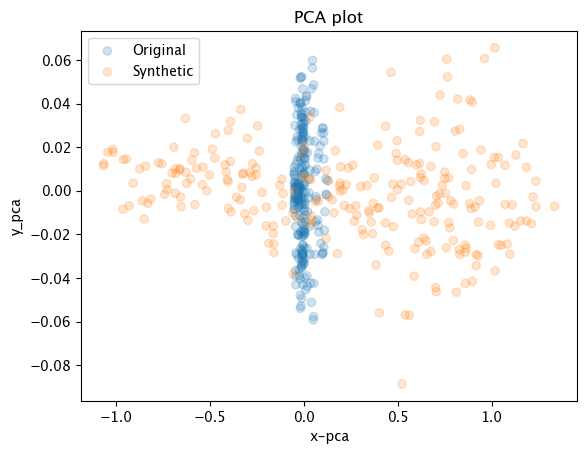

In [77]:
visualization(trainmos[:len(syn_stress)], syn_stress, "pca")

/Users/nils/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/nils/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.089s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.063447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.098122
[t-SNE] KL divergence after 300 iterations: 0.777167


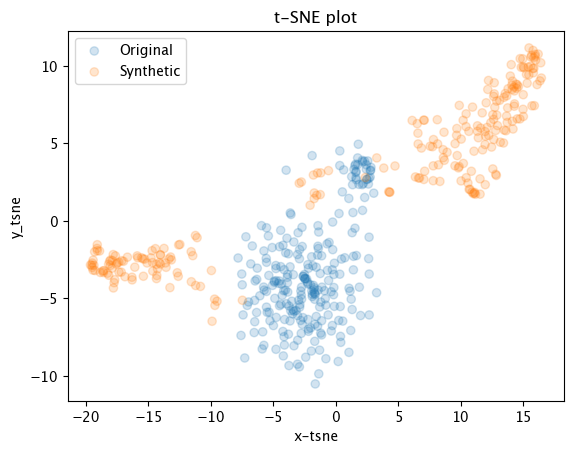

In [78]:
visualization(trainmos[:len(syn_stress)], syn_stress, "tsne")

### 2. Fidelity

In [164]:
import pandas as pd
import numpy as np

def reverse_sliding_window(sequence: np.array, column_names: list) -> pd.DataFrame:
    """reverse sliding_window() function and create new DataFrame

    Args:
        sequence (np.array): window with physiological measurements
        column_names (list): list of column names from the original DataFrame

    Returns:
        pd.DataFrame: new DataFrame with sliding window values
    
    """
    num_values = sequence.shape[2]
    num_rows = sequence.shape[0] * sequence.shape[1]
    data = np.reshape(sequence, (num_rows, num_values))
    columns = [f"{name}_{i}" for i in range(num_values) for name in column_names]
    return pd.DataFrame(data=data, columns=columns)


In [46]:
def sliding_window(data: pd.DataFrame, seq_length: int) -> np.array:
    """create a sliding window from physiological measurement data

    Args:
        data (pd.DataFrame): pandas Dataframe object containing physiological measurements
        seq_length (int): the size of the window

    Returns:
        np.array: return window with physiological measurements
    
    Example
    --------
    >>> from Data_Generation.preprocessing.resample import sliding_window
    >>> df = pd.read_csv('*.csv')
    >>> sequence = sliding_window(df, 16)
    >>> sequence[0]
    [[ 1.80302907e-03 -1.10408072e+00  0.00000000e+00]
    [ 3.10873729e-03 -9.98765954e-01  0.00000000e+00]
    [ 2.22844462e-03 -9.00125796e-01  0.00000000e+00]
    [ 4.62524202e-04 -8.02918769e-01  0.00000000e+00]
    [-2.46748674e-04 -7.08045935e-01  0.00000000e+00]
    [ 1.57798674e-03 -6.17339079e-01  0.00000000e+00]
    [ 7.33943580e-04 -5.31785943e-01  0.00000000e+00]
    [ 3.08093724e-05 -4.51740181e-01  0.00000000e+00]
    [ 4.07566970e-04 -3.78206543e-01  0.00000000e+00]
    [-3.17091829e-04 -3.13150623e-01  0.00000000e+00]
    [ 9.84478452e-04 -2.53597259e-01  0.00000000e+00]
    [ 1.20569931e-03 -1.97316632e-01  0.00000000e+00]
    [-9.54995935e-04 -1.43637691e-01  0.00000000e+00]
    [ 5.99781111e-04 -9.26586467e-02  0.00000000e+00]
    [ 1.71259950e-03 -4.47264303e-02  0.00000000e+00]
    [ 2.90194051e-03 -1.59274298e-04  0.00000000e+00]]"""


    # Exclude 
    container = data.loc[:, data.columns!='time_iso']
    container_array = np.array(container)

    return np.array([container_array[i : i + seq_length] for i in range(0, container_array.shape[0] - seq_length)])

In [47]:
pd.DataFrame(np.array(df_stress), columns=list(SIGTOI.keys()))

BVP       EDA     ACC_x     ACC_y     ACC_z      TEMP
0     0.468149  0.474020  0.419026  0.058139  0.564404  0.442450
1     0.580791  0.465606  0.380185  0.048626  0.545889  0.440526
2     0.535289  0.464349  0.386764  0.048625  0.529446  0.442391
3     0.529677  0.464895  0.493331  0.080464  0.476120  0.440416
4     0.616257  0.456615  0.392069  0.052896  0.535317  0.442802
...        ...       ...       ...       ...       ...       ...
9961  0.464562  0.093303  0.302460  0.406114  0.638581  0.451159
9962  0.514509  0.105320  0.639227  0.036187  0.515114  0.427489
9963  0.401539  0.097959  0.689817  0.018614  0.515933  0.422366
9964  0.256045  0.058040  0.256639  0.324257  0.517111  0.421627
9965  0.552329  0.112766  0.229436  0.525320  0.750153  0.424756

[9966 rows x 6 columns]

In [48]:
container_array = np.array(df_stress)

In [49]:
container_array.shape

(9966, 6)

In [50]:
fin = np.array([container_array[i : i + seq_length] for i in range(0, container_array.shape[0] - seq_length)])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/nils/miniconda3/envs/cgan/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/3k/sjklqbj91hg9fgb_kbwpy1p40000gn/T/ipykernel_22438/497979989.py", line 1, in <module>
    fin = np.array([container_array[i : i + seq_length] for i in range(0, container_array.shape[0] - seq_length)])
NameError: name 'seq_length' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nils/miniconda3/envs/cgan/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/nils/miniconda3/envs/cgan/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/nils/miniconda3/envs/cgan/lib/python3.8

In [322]:
syn_stress

<tf.Tensor: shape=(200, 16, 6), dtype=float64, numpy=
array([[[ 0.45427415,  0.27168684, -0.07823094,  0.52272856,
          0.45712158,  0.80725864],
        [ 0.44045857,  0.00250217,  0.1262252 ,  0.21687122,
          0.09313403,  1.01109411],
        [ 0.37221103, -0.11069619, -0.06607331, -0.00868297,
          0.93378882,  1.06880913],
        ...,
        [ 0.45101612,  0.36574554,  0.09640769,  0.42638945,
          0.70977008,  0.50346133],
        [ 0.38434304,  0.56440927,  0.21057556,  0.36276194,
          0.77431254,  0.75110432],
        [ 0.62169445,  0.70180378,  0.49252101,  0.07564319,
          0.88238624,  0.61550612]],

       [[ 0.48120454,  0.26409709, -0.08340398,  0.51939502,
          0.42374337,  0.75795858],
        [ 0.42589514,  0.00119136,  0.14067282,  0.22446297,
          0.06096883,  0.95675484],
        [ 0.43043047, -0.16389429, -0.14373267,  0.05446411,
          0.94757562,  0.95685148],
        ...,
        [ 0.42055695,  0.73252308,  0.6628672

In [51]:
import numpy as np

# create an array of shape (200, 16, 6)
arr = np.random.rand(200, 16, 6)

# reshape the array to shape (200*16, 6)
reshaped_arr = np.reshape(arr, (200*16, 6))

In [60]:
real_stress = trainmos[:200]

In [61]:
real_stress.shape

(200, 16, 6)

In [62]:
real = np.reshape(real_stress, (200*16, 6))

In [52]:
syn = np.reshape(syn_stress, (200*16, 6))

In [63]:
df_syn = pd.DataFrame(syn, columns=list(SIGTOI.keys()))

In [64]:
df_real = pd.DataFrame(real, columns=list(SIGTOI.keys()))

In [65]:
df_stress.shape

(9966, 6)

In [69]:
df_syn.shape

(3200, 6)

In [75]:
signal = "ACC_x"

<Axes: >

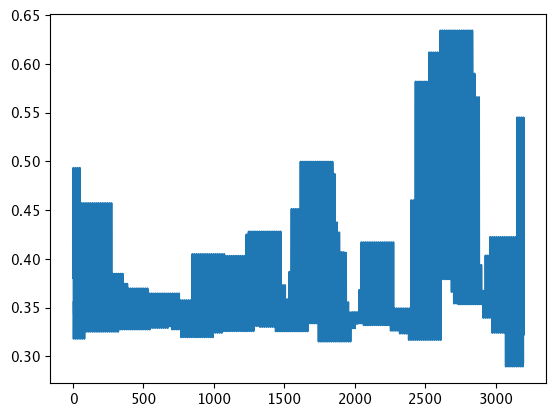

In [76]:
df_real[signal].plot()

<Axes: >

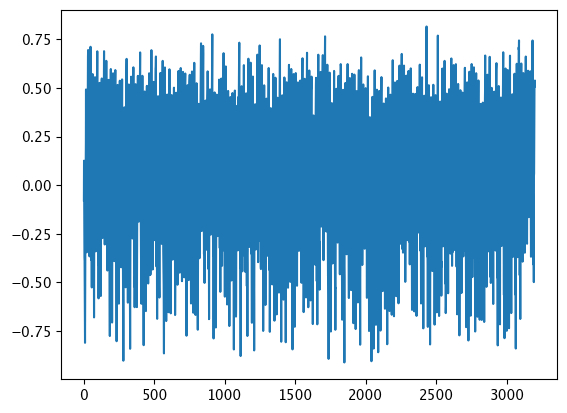

In [77]:
df_syn[signal].plot()

### 3. Usefulness

In [ ]:
## CHATGPT reverse sliding window function
def reverse_sliding_window(windowed_data: np.array, seq_length: int) -> pd.DataFrame:
    """Reverse a sliding window operation on a numpy array of physiological measurement data

    Args:
        windowed_data (np.array): numpy array of windowed physiological measurements
        seq_length (int): the size of the window

    Returns:
        pd.DataFrame: pandas DataFrame object containing original physiological measurements
    """
    n_windows = windowed_data.shape[0]
    n_samples = n_windows * (seq_length - 1) + seq_length

    original_data = np.zeros((n_samples, windowed_data.shape[1]))

    for i, window in enumerate(reversed(windowed_data)):
        start_idx = n_samples - (i+1) * (seq_length - 1) - seq_length
        end_idx = start_idx + seq_length
        original_data[start_idx:end_idx, :] = window

    original_df = pd.DataFrame(original_data, columns=data.columns)

    # Remove any extra rows that may have been added during sliding window operation
    original_df = original_df[:n_samples - (seq_length - 1)]

    return original_df

In [73]:
def create_subwindows_new(window: np.array, signal_subwindow_len: int, signal_name: str, fs: int) -> np.array:
    """The function creates subwindows from the windows.

    Args:
        df (pd.DataFrame): Windows representing the activity of the subject in one minute.
        signal_subwindow_len (int): Length of the subwindows.
        signal_name (str): Name of the signal.
        fs (int): Samples per second

    Returns:
        list: Subwindows of the signal in the window.
    """

    subwindow_len = fs * signal_subwindow_len # fs = 64 and sub-window length in seconds = 30
    window_len = fs * 60 # fs = 64 and window length in seconds = 60
    window_shift = 1 if fs < 4 else int(fs * 0.25) # fs = 64 and window shift in seconds = 0.25

    subwindows = np.asarray([window[i:i+subwindow_len] for i in range(0, window_len - subwindow_len + 1, window_shift)])
            
    return subwindows

## MISC

### Sliding Window creation

In [ ]:
def sliding_window(data: pd.DataFrame, seq_length: int) -> np.array:
    """create a sliding window from physiological measurement data

    Args:
        data (pd.DataFrame): pandas Dataframe object containing physiological measurements
        seq_length (int): the size of the window

    Returns:
        np.array: return window with physiological measurements
    
    Example
    --------
    >>> from Data_Generation.preprocessing.resample import sliding_window
    >>> df = pd.read_csv('*.csv')
    >>> sequence = sliding_window(df, 16)
    >>> sequence[0]
    [[ 1.80302907e-03 -1.10408072e+00  0.00000000e+00]
    [ 3.10873729e-03 -9.98765954e-01  0.00000000e+00]
    [ 2.22844462e-03 -9.00125796e-01  0.00000000e+00]
    [ 4.62524202e-04 -8.02918769e-01  0.00000000e+00]
    [-2.46748674e-04 -7.08045935e-01  0.00000000e+00]
    [ 1.57798674e-03 -6.17339079e-01  0.00000000e+00]
    [ 7.33943580e-04 -5.31785943e-01  0.00000000e+00]
    [ 3.08093724e-05 -4.51740181e-01  0.00000000e+00]
    [ 4.07566970e-04 -3.78206543e-01  0.00000000e+00]
    [-3.17091829e-04 -3.13150623e-01  0.00000000e+00]
    [ 9.84478452e-04 -2.53597259e-01  0.00000000e+00]
    [ 1.20569931e-03 -1.97316632e-01  0.00000000e+00]
    [-9.54995935e-04 -1.43637691e-01  0.00000000e+00]
    [ 5.99781111e-04 -9.26586467e-02  0.00000000e+00]
    [ 1.71259950e-03 -4.47264303e-02  0.00000000e+00]
    [ 2.90194051e-03 -1.59274298e-04  0.00000000e+00]]"""


    # Exclude 
    container = data.loc[:, data.columns!='time_iso']
    container_array = np.array(container)

    return np.array([container_array[i : i + seq_length] for i in range(0, container_array.shape[0] - seq_length)])

In [26]:
# s2 = Subject(DATA_PATH, 2)
# df = s2.get_subject_dataframe(sampling_rate=1)
# df = s2.get_subject_dataframe(sampling_rate=1)[:2080]
# df = s2.get_subject_dataframe(sampling_rate=1)
# df = df.drop(['EDA', 'ACC_x', 'ACC_y', 'ACC_z'], axis=1)
df_label = df['label']
df_stress = df[df['label']==1].drop('label', axis=1).reset_index(drop=True)
df_no_stress = df[df['label']==0].drop('label', axis=1).reset_index(drop=True)
df.drop('label', axis=1, inplace=True)

In [ ]:
label_trainX = df_label.to_numpy()[:len(trainX)]
df_label = df['label']
df_stress = df[df['label']==1].drop('label', axis=1).reset_index(drop=True)
df_no_stress = df[df['label']==0].drop('label', axis=1).reset_index(drop=True)
df.drop('label', axis=1, inplace=True)

In [ ]:
seq_length = 60
trainX = sliding_window(df, seq_length)
mos = sliding_window(df_stress, seq_length)#[:512]
non_mos = sliding_window(df_no_stress, seq_length)#[:1280]